In [1]:
import numpy as np
import os
import sys
import cv2
import glob
import json
import random

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm 
from tensorflow.keras import Model
from tensorflow.keras.utils import normalize
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tfdiffeq.models.dense_odenet import ODEBlock
from tfdiffeq.models.conv_odenet import Conv2dTime
from preprocess_data import read_json, read_image_strings

In [2]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
NUM_IMAGES = 500
NUM_CLASSES = 6

TRAIN_PATH = 'data/train_set/'
TEST_PATH = 'data/test_set/'

In [3]:
data_train = read_json(TRAIN_PATH,'label_data_*.json')
data_test = read_json(TEST_PATH,'test_label.json')

train_paths = glob.glob(TRAIN_PATH + 'labelled/multi/images/*.png')
train_paths.sort()
train_paths = train_paths[:NUM_IMAGES]
train_labels = glob.glob(TRAIN_PATH + 'labelled/multi/labels/*.png')
train_labels.sort()
train_labels = train_labels[:NUM_IMAGES]
test_paths = glob.glob(TEST_PATH + 'labelled/multi/images/*.png')
test_paths.sort()
test_paths = test_paths[:NUM_IMAGES]
test_labels = glob.glob(TEST_PATH + 'labelled/multi/labels/*.png')
test_labels.sort()
test_labels = test_labels[:NUM_IMAGES]

['data/train_set/label_data_0531.json', 'data/train_set/label_data_0313.json', 'data/train_set/label_data_0601.json']
Number of labeled images: 3626
data keys: dict_keys(['lanes', 'h_samples', 'raw_file'])
['data/test_set/test_label.json']
Number of labeled images: 2782
data keys: dict_keys(['lanes', 'h_samples', 'raw_file'])


Load images and masks in order so they match

In [4]:
print('Resizing training images and masks')

X_train = []
for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):   
    img = imread(path)[:,:,:IMG_CHANNELS]  
    # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_NEAREST)
    X_train.append(img)
X_train = np.array(X_train)

Resizing training images and masks


100%|██████████| 500/500 [00:37<00:00, 13.32it/s]


In [5]:
Y_train = []
for n, path in tqdm(enumerate(train_labels), total=len(train_labels)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_NEAREST)  
        
    Y_train.append(mask) 
Y_train = np.array(Y_train)

100%|██████████| 500/500 [00:09<00:00, 50.29it/s]


In [6]:
# Encode train labels
labelencoder = LabelEncoder()
n, h, w = Y_train.shape
Y_train_reshaped = Y_train.reshape(-1,1)
Y_train_encoded = labelencoder.fit_transform(Y_train_reshaped)
Y_train = Y_train_encoded.reshape(n, h, w)
Y_train = np.expand_dims(Y_train, axis=3)

# Convert to categorical
Y_train_cat = to_categorical(Y_train, num_classes=NUM_CLASSES)

/home/moriyama/richard/.conda/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
X_test = []
for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
    img = imread(path)[:,:,:IMG_CHANNELS]
    # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_NEAREST)
    X_test.append(img)
X_test = np.array(X_test)

100%|██████████| 500/500 [00:33<00:00, 14.80it/s]


In [5]:
Y_test = []
for n, path in tqdm(enumerate(test_labels), total=len(test_labels)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_NEAREST)
        
    Y_test.append(mask)
Y_test = np.array(Y_test) 

100%|██████████| 500/500 [00:12<00:00, 40.34it/s]


In [6]:
# Encode test labels
labelencoder = LabelEncoder()
n, h, w = Y_test.shape
Y_test_reshaped = Y_test.reshape(-1,1)
Y_test_encoded = labelencoder.fit_transform(Y_test_reshaped)
Y_test = Y_test_encoded.reshape(n, h, w)
Y_test = np.expand_dims(Y_test, axis=3)

# Convert to categorical
Y_test_cat = to_categorical(Y_test, num_classes=NUM_CLASSES)

/home/moriyama/richard/.conda/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# Print data shapes
print("Train data shape is: ", X_train.shape)
print("Train label shape is: ", Y_train.shape)
print("Max pixel value in image is: ", X_train.max())
print("Labels in the mask are : ", np.unique(Y_train))

Train data shape is:  (500, 256, 256, 3)
Train label shape is:  (500, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


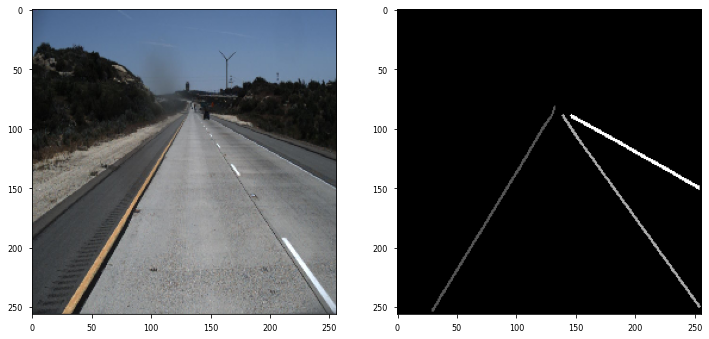

In [9]:
# Visualize random image and label
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(Y_test[image_number], cmap='gray')
plt.show()

In [10]:
import tensorflow as tf

from typing import Any
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tfdiffeq.models.dense_odenet import ODEBlock
from tfdiffeq.models.conv_odenet import Conv2dTime

MAX_NUM_STEPS = 1000 # Maximum number of steps for ODE solver

def get_non_linearity(name: str)->tf.keras.layers.Layer:
    """Resolve non-linearity to layer

    Arguments:
        name {str} -- name of non-linearity/activation function

    Returns:
        tf.keras.layers.Layer -- target activation layer
    """
    if name == 'relu':
        return tf.keras.layers.ReLU()
    elif name == 'softplus':
        return tf.keras.layers.Activation('softplus')
    elif name == 'lrelu':
        return tf.keras.layers.LeakyReLU(alpha=0.2)
    elif name == 'swish':
        return tf.keras.layers.Activation('swish')
    else:
        return tf.keras.layers.Activation(name)    

class Conv2dODEFunc(Model):

    def __init__(self, num_filters, augment_dim=0,
                 time_dependent=False, non_linearity='relu', **kwargs):
        """
        Convolutional block modeling the derivative of ODE system.
        # Arguments:
            num_filters : int
                Number of convolutional filters.
            augment_dim: int
                Number of augmentation channels to add. If 0 does not augment ODE.
            time_dependent : bool
                If True adds time as input, making ODE time dependent.
            non_linearity : string
                Activation function for activation layer. One of 'relu', 'softplus', 
                'lrelu' and 'swish'
        """
        dynamic = kwargs.pop('dynamic', True)
        super(Conv2dODEFunc, self).__init__(**kwargs, dynamic=dynamic)

        self.augment_dim = augment_dim
        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations
        self.num_filters = num_filters
        self.input_dim = input

        if time_dependent:
            self.norm1 = BatchNormalization()
            self.conv1 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=0)
            self.norm2 = BatchNormalization()
            self.conv2 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=1)

        else:
            self.norm1 = BatchNormalization()
            self.conv1 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
            self.norm2 = BatchNormalization()
            self.conv2 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')

        self.non_linearity = get_non_linearity(non_linearity)
            
    def build(self, input_shape):
        if input_shape:
            self.built = True
        

    @tf.function
    def call(self, t, x, training=None, **kwargs):
        """
        Parameters
        ----------
        t : Tensor
            Current time.
        x : Tensor
            Shape (batch_size, input_dim)
        """

        self.nfe += 1

        if self.time_dependent:
            out = self.norm1(x)
            out = self.conv1(t, x)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(t, out)
            out = self.non_linearity(out)
        else:
            out = self.norm1(x)
            out = self.conv1(out)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(out)
            out = self.non_linearity(out)

        return out
class UNode(Model):
    """Creates a U-Net with an ODEBlock and a convolutional ODEFunc, therefore a U-Node
    Parameters
    ----------
    num_filters : int
        Number of convolutional filters.
    input_dim : tuple of ints
        Tuple of (height, width, channels).
    output_dim : int
        Dimension of output after hidden layer. Should be 1 for regression or
        num_classes for classification.
    augment_dim: int
        Number of augmentation channels to add. If 0 does not augment ODE.
    time_dependent : bool
        If True adds time as input, making ODE time dependent.
    non_linearity : string
        Activation function for activation layer. One of 'relu', 'softplus', 
        'lrelu' and 'swish'
    tol : float
        Error tolerance.
    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    solver: ODE solver. Defaults to DOPRI5.
    """
    def __init__(self, num_filters, input_dim, output_dim=1,
                 augment_dim=0, time_dependent=False, non_linearity='relu', out_strides=(1, 1),
                 tol=1e-3, adjoint=False, solver='dopri5', **kwargs):

        dynamic = kwargs.pop('dynamic', True)
        super(UNode, self).__init__(**kwargs, dynamic=dynamic)

        self.nf = num_filters
        self.augment_dim = augment_dim
        self.output_dim = output_dim
        self.time_dependent = time_dependent
        self.tol = tol
        self.solver = solver
        self.output_strides = out_strides
        self.input_dim = input_dim
        self.non_linearity = get_non_linearity(non_linearity)

        self.input_layer = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same', input_shape=input_dim)
        self.norm_range = tf.keras.layers.Lambda(lambda x: x / 255)

        #Contraction path
        ode_down1 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down1 = ODEBlock(odefunc=ode_down1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down1_2 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))

        ode_down2 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down2 = ODEBlock(odefunc=ode_down2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down2_3 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))

        ode_down3 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down3 = ODEBlock(odefunc=ode_down3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down3_4 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2))

        ode_down4 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down4 = ODEBlock(odefunc=ode_down4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down4_embed = Conv2D(filters=num_filters*16, kernel_size=(1, 1), padding='same')
        self.maxpool4 = MaxPooling2D(pool_size=(2, 2))

        ode_embed = Conv2dODEFunc(num_filters=num_filters*16, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_embending = ODEBlock(odefunc=ode_embed, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        #Expansive path
        self.transpose1 = Conv2DTranspose(filters=num_filters*8, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up_embed_1 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        ode_up1 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up1 = ODEBlock(odefunc=ode_up1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose2 = Conv2DTranspose(filters=num_filters*4, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up1_2 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        ode_up2 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up2 = ODEBlock(odefunc=ode_up2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose3 = Conv2DTranspose(filters=num_filters*2, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up2_3 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        ode_up3 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up3 = ODEBlock(odefunc=ode_up3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose4 = Conv2DTranspose(filters=num_filters, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up3_4 = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same')
        ode_up4 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up4 = ODEBlock(odefunc=ode_up4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.classifier = Conv2D(filters=output_dim, kernel_size=(1, 1), activation='softmax')


    def call(self, inputs, return_features: bool=False):
        
        norm_inputs = self.norm_range(inputs)
        inps = self.input_layer(norm_inputs)
        x_cast = tf.cast(inps, dtype=tf.float64)
        
        # Contraction path
        features1 = self.odeblock_down1(x_cast)
        x = self.non_linearity(self.conv_down1_2(features1))
        x = self.maxpool1(x)
        x = Dropout(0.1)(x)

        features2 = self.odeblock_down2(x)
        x = self.non_linearity(self.conv_down2_3(features2))
        x = self.maxpool2(x)
        x = Dropout(0.1)(x)

        features3 = self.odeblock_down3(x)
        x = self.non_linearity(self.conv_down3_4(features3))
        x = self.maxpool3(x)
        x = Dropout(0.2)(x)

        features4 = self.odeblock_down4(x)
        x = self.non_linearity(self.conv_down4_embed(features4))
        x = self.maxpool4(x)
        x = Dropout(0.2)(x)

        x = self.odeblock_embending(x)

        #Expansive path
        x = self.transpose1(x)
        x = concatenate([x, features4])
        x = self.non_linearity(self.conv_up_embed_1(x))
        x = self.odeblock_up1(x)

        x = self.transpose2(x)
        x = concatenate([x, features3])
        x = self.non_linearity(self.conv_up1_2(x))
        x = self.odeblock_up2(x)

        x = self.transpose3(x)
        x = concatenate([x, features2])
        x = self.non_linearity(self.conv_up2_3(x))
        x = self.odeblock_up3(x)

        x = self.transpose4(x)
        x = concatenate([x, features1])
        x = self.non_linearity(self.conv_up3_4(x))
        x = self.odeblock_up4(x)

        pred = self.classifier(x)

        if return_features:
            return features4, pred
        else:
            return pred

# Get U-Node model
def get_unode_model(input_dim: tuple, filters: int=4, output_dim=6, non_linearity: str='lrelu', solver: str='adams') -> UNode:
    """Get an instance of UNode model

    Arguments:
        input_dim {tuple} -- shape of input in the form (height, width, channels) e.g. (256, 256, 3)

    Keyword Arguments:
        filters {int} -- number of filters to apply in convolutions (default: {4})
        non_linearity {str} -- activation function (default: {'lrelu'})
        solver {str} -- ODE solver to be applied (default: {'adams'})

    Returns:
        UNode -- an instance of the UNode model class
    """
    return UNode(num_filters=filters, input_dim=input_dim, output_dim=output_dim, non_linearity=non_linearity, solver=solver)

In [13]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = UNode(num_filters=8, input_dim=input_shape, output_dim=NUM_CLASSES, non_linearity='lrelu', solver='adams')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2022-04-24 22:17:47.324365: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-24 22:17:49.929535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10783 MB memory:  -> device: 0, name: Tesla K40m, pci bus id: 0000:02:00.0, compute capability: 3.5


In [14]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('saved_model/unode_multi/', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]

In [15]:
results = model.fit(X_train, Y_train_cat, validation_split=0.2, batch_size=2, epochs=5, callbacks=callbacks)

2022-04-24 22:17:51.773904: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-24 22:17:54.969419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-24 22:17:57.335771: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-24 22:17:57.336645: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-24 22:17:57.336694: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-04-24 22:17:57.337330: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-24 22:17:57.337405: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


200/200 [==============================] - 572s 3s/step - loss: 0.4036 - accuracy: 0.8876 - val_loss: 0.1806 - val_accuracy: 0.9778
Epoch 2/5
200/200 [==============================] - 549s 3s/step - loss: 0.0949 - accuracy: 0.9799 - val_loss: 0.1437 - val_accuracy: 0.9777
Epoch 3/5
200/200 [==============================] - 557s 3s/step - loss: 0.0776 - accuracy: 0.9802 - val_loss: 0.1383 - val_accuracy: 0.9777
Epoch 4/5
200/200 [==============================] - 560s 3s/step - loss: 0.0691 - accuracy: 0.9806 - val_loss: 0.1414 - val_accuracy: 0.9778
Epoch 5/5
200/200 [==============================] - 560s 3s/step - loss: 0.0657 - accuracy: 0.9812 - val_loss: 0.1382 - val_accuracy: 0.9779


In [16]:
# Save model weights
model.save_weights('saved_model/unode_multi/unode.tf')

In [12]:
## Load and build saved model
# Get instance of model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
unode_model = get_unode_model(filters=8, input_dim=input_shape, output_dim=NUM_CLASSES, non_linearity='lrelu', solver='adams')
# Compile model
unode_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# initialize/build model by predicting on zeroes tensor
init_preds = unode_model.predict(np.zeros((1, 256, 256, 3)))

2022-04-25 14:10:54.750187: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 14:10:57.519017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4093 MB memory:  -> device: 0, name: Tesla K20m, pci bus id: 0000:03:00.0, compute capability: 3.5
2022-04-25 14:10:58.594887: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-25 14:11:02.052527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-25 14:11:04.346465: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directo

In [13]:
# Load weights
unode_model.load_weights('multi_class/result/main_run/saved_model/unode.tf')

In [22]:
unode_model.summary()

Model: "u_node_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu_10 (LeakyReLU)   multiple                  0         
_________________________________________________________________
conv2d_28 (Conv2D)           multiple                  16        
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0         
_________________________________________________________________
ode_block_9 (ODEBlock)       multiple                  328       
_________________________________________________________________
conv2d_31 (Conv2D)           multiple                  40        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
ode_block_10 (ODEBlock)      multiple                  123

In [28]:
model.summary()

Model: "u_node"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  16        
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
ode_block (ODEBlock)         multiple                  328       
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
ode_block_1 (ODEBlock)       multiple                  1232 

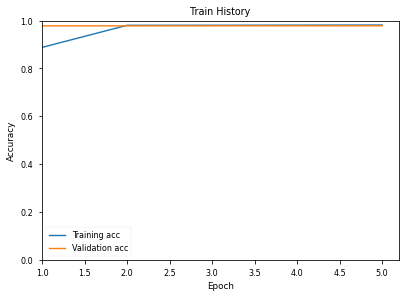

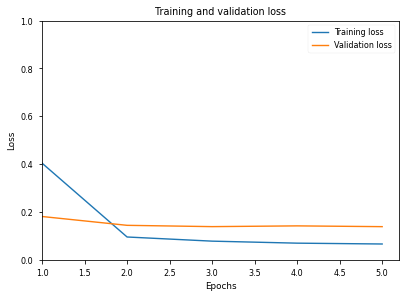

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, results.history['accuracy'])
plt.plot(epochs, results.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xlim(xmin=1)
plt.legend(['Training acc', 'Validation acc'], loc='best')
plt.show()

# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

loss = results.history['loss']
val_loss = results.history['val_loss']
plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.xlim(xmin=1)
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [19]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

16/16 [==============================] - 45s 3s/step


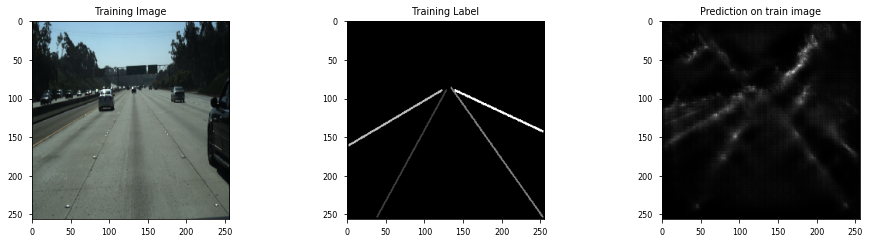

In [20]:
# Perform a sanity check on some random train samples
ix = random.randint(0, len(preds_train))

# pred_image = np.argmax(preds_train[ix], axis=2)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(X_train[ix])
plt.subplot(232)
plt.title('Training Label')
plt.imshow(Y_train[ix][:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(preds_train[ix][:,:,1], cmap='gray')

plt.show()

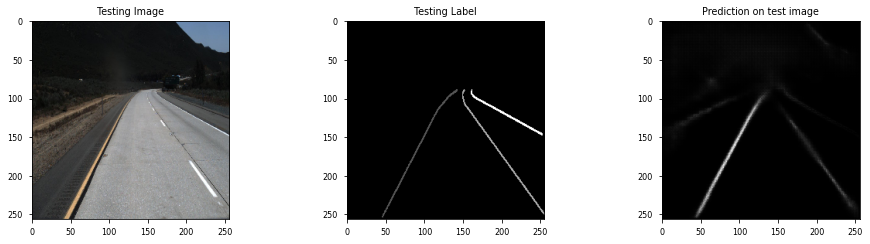

In [21]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test))

# pred_image = np.argmax(preds_test[ix], axis=3)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(X_test[ix])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(Y_test[ix][:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(preds_test[ix][:,:,1], cmap='gray')


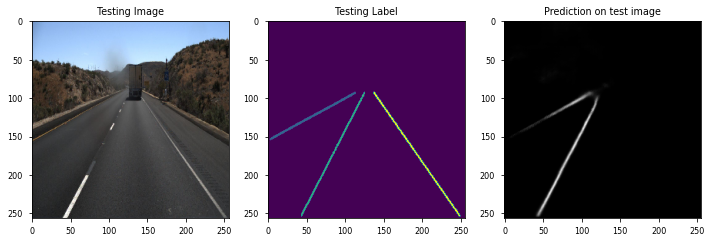

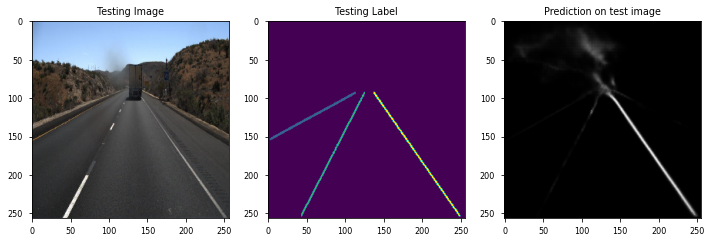

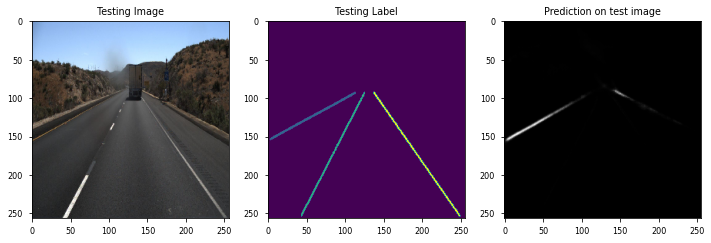

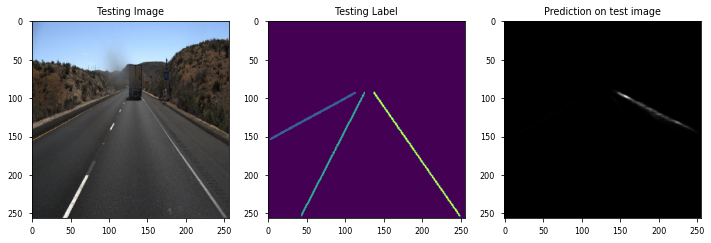

In [21]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
img = test_img.reshape(1,256,256,3)
ground_truth=Y_test[test_img_number]
prediction = (unode_model.predict(img))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,1], cmap='gray')
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,2], cmap='gray')
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,3], cmap='gray')
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,4], cmap='gray')
plt.show()

In [27]:
print(np.max(prediction[0,:,:,4]))

0.34092477


In [29]:
#   prediction_1 = prediction # Already predicted image
prediction_1 =np.squeeze(prediction)
# group_prediction=np.zeros([256,256,4])
tol_dis=81
tol_invtan=5*10**(-3)
predim2=np.zeros([256,256])
predim3=np.zeros([256,256])
for j in range(1,5):
    group1=np.array([])
    group2=np.array([])
    predim1=np.zeros([256,256])
    for y_coord in range(85,256):
        row=prediction[y_coord,:,j]
        prob=np.amax(row)       
        if prob>0.1:
            x_coord=np.amin(np.squeeze(np.where(row == prob)))
            predim1[y_coord,x_coord]=1
        else:
            continue
        group1add=group1.size==0 or (group1.size==2 and near_smooth(group1[0],[y_coord,x_coord],group1[-1],tol_dis,0,True)) or (group1.size>2 and near_smooth(group1[-1],[y_coord,x_coord],group1[-2],tol_dis,tol_invtan,False))
        group2add=group2.size==0 or (group2.size==2 and near_smooth(group2[0],[y_coord,x_coord],group2[-1],tol_dis,0,True)) or (group2.size>2 and near_smooth(group2[-1],[y_coord,x_coord],group2[-2],tol_dis,tol_invtan,False))
        if group1.size>0 and group2.size>0 and group1add and group2add:
            group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
            group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
        elif group1add:
            group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
        elif group1.size>0 and group2add:
            group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
        else:
            if group1.size<=group2.size:
                group1=group2
            group2=np.array([[y_coord,x_coord]])
    if group1.size<=group2.size:
        group1=group2
    group1=group1.astype('int64')
    if group1.size<50 :
        continue
    if group1[0,0]>85:
        t=group1[0:11,0]
        xn=group1[0:11,1]
        f = np.poly1d(np.polyfit(t, xn, 1))
        for i in range(round(group1[0,0])-1,84,-1):
            guess=round(f(i))
            if 0<guess<256:
                 group1=np.reshape(np.insert(group1,0,[i,guess],),(-1,2))
            else:
                break
    if group1[-1,0]<256:
        t=group1[-12:-1,0]
        xn=group1[-12:-1,1]
        f = np.poly1d(np.polyfit(t, xn, 1))
        for i in range(round(group1[-1,0])+1,256):
            guess=round(f(i))
            if 0<guess<256:
                 group1=np.reshape(np.append(group1,[i,guess],),(-1,2))
            else:
                break
    for i in range (85,min(254,group1[-1,0])-2):
        if group1[i-85,0]!=i:
            t=group1[i-86:i-84,0]
            xn=group1[i-86:i-84,1]
            f = np.poly1d(np.polyfit(t, xn, 1))
            guess=[[i,round(f(i))]for i in range(i,group1[i-85,0])]
            group1=np.insert(group1,i-85,guess,axis=0)
        predim2[group1[i-85,0],group1[i-85,1]]=j
predim2=predim2.astype('uint8')

IndexError: index 85 is out of bounds for axis 0 with size 1

In [ ]:
print(predim2.shape)

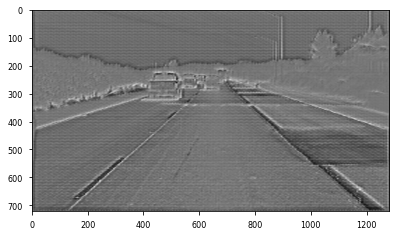

In [48]:
rand_images = random.sample(range(X_test.shape[0]), 10)
for i in rand_images:
    _, filename = os.path.split(test_paths[i])
    test_img = X_test[i]
    img = test_img.reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    ground_truth=Y_test_cat[i]
    prediction = unode_model.predict(img)
    predicted_img = prediction[0,:,:,1]#np.argmax(prediction, axis=3)[0,:,:]
    res = cv2.resize(predicted_img, dsize=(1280, 720), interpolation=cv2.INTER_CUBIC)
    plt.imshow(res, cmap='gray')
#     plt.imsave(os.path.join(pred_path, filename), res, cmap='gray')
    